In [1]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
wordnet = WordNetLemmatizer()
snowballstemmer = SnowballStemmer("english")
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wangjiayun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

In [3]:
biden_url = 'Biden Tweets - Biden_Tweets copy.csv'
biden = pd.read_csv(biden_url, error_bad_lines= False).drop(['Unnamed: 1', 'Username'], axis = 1)
biden = biden.dropna(subset=["Text"]).reset_index()

In [4]:
#biden

In [5]:
from unidecode import unidecode
from re import sub

def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()
    
    if 'pic.twitter' in text:
        text = 'empty'

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ", text)
    text = sub(r"\?", " ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " ", text)
    text = sub(r"\s{2,}", " ", text)
    text = sub(r'http\S+', '', text)

    text = text.split()
    text = list(filter(lambda x: len(x) > 1, text))

    return text  

In [6]:
biden["Cleaned_Text"] = biden["Text"].apply(lambda x: text_to_word_list(x, unidecode))

In [7]:
def empty(text):
    is_empty = False
    if text == ['empty']:
        is_empty = True
    return is_empty

def filter_df(df):
    df["is_empty"] = df["Cleaned_Text"].apply(lambda x: empty(x))
    df_filtered = df[df["is_empty"] == False]
    final_df = df_filtered.drop(["is_empty"], axis = 1)
    return final_df

biden = filter_df(biden).reset_index(drop=True)

In [8]:
biden.head()

,index,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment,Cleaned_Text
0,0,Thu Apr 25 16:59:59 +0000 2019,0,"And, we have President Trump to thank.",NaN,NaN,0.0,"[and, we, have, president, trump, to, thank]"
1,2,Thu Apr 25 16:59:58 +0000 2019,0,The “hang em high” references were less than s...,NaN,NaN,0.0,"[the, hang, em, high, references, were, less, ..."
2,3,Thu Apr 25 16:59:57 +0000 2019,0,"Donald Trump Makes Joe Biden’s Point, Mocking ...",NaN,NaN,-1.0,"[donald, trump, makes, joe, biden, point, mock..."
3,4,Thu Apr 25 16:59:57 +0000 2019,0,"Factually speaking, that’s not accurate. Trump...",NaN,NaN,-1.0,"[factually, speaking, that, not, accurate, tru..."
4,5,Thu Apr 25 16:59:57 +0000 2019,0,HAAAAAA!!!,NaN,NaN,0.0,[haaaaaa]


In [9]:
sentences = biden["Cleaned_Text"].apply(lambda x: " ".join(x))
#sentences

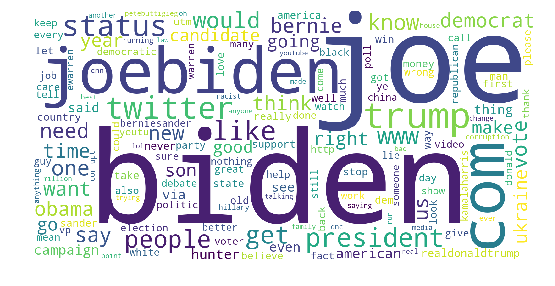

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(sentences)) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [12]:
tokenized_tweet = biden["Cleaned_Text"]
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0            [and, we, have, presid, trump, to, thank]
1    [the, hang, em, high, refer, were, less, than,...
2    [donald, trump, make, joe, biden, point, mock,...
3    [factual, speak, that, not, accur, trump, ha, ...
4                                            [haaaaaa]
Name: Cleaned_Text, dtype: object

In [13]:
tokenized_tweet = tokenized_tweet.reset_index(drop=True)
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

biden['Cleaned_Text'] = tokenized_tweet

In [14]:
biden["Cleaned_Text"].head()

0                    and we have presid trump to thank
1          the hang em high refer were less than subtl
2    donald trump make joe biden point mock candid ...
3    factual speak that not accur trump ha been acc...
4                                              haaaaaa
Name: Cleaned_Text, dtype: object

In [15]:
biden.drop_duplicates(subset=['Cleaned_Text'], keep = 'first',inplace= True)

In [16]:
biden.reset_index(drop=True,inplace=True)

In [17]:
from textblob import TextBlob

def calculate_sentiment(Clean_text):
    return TextBlob(Clean_text).sentiment

def calculate_sentiment_analyser(Clean_text):    
    return analyser.polarity_scores(Clean_text)

In [64]:
calculate_sentiment_analyser("happy")

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}

In [19]:
biden['sentiment']=biden.Cleaned_Text.apply(calculate_sentiment)
biden['sentiment_analyser']=biden.Cleaned_Text.apply(calculate_sentiment_analyser)


s = pd.DataFrame(index = range(0,len(biden)),columns= ['compound_score','compound_score_sentiment'])

for i in range(0,len(biden)): 
    s['compound_score'][i] = biden['sentiment_analyser'][i]['compound']
  
    if (biden['sentiment_analyser'][i]['compound'] <= -0.05):
        s['compound_score_sentiment'][i] = 'Negative'    
    if (biden['sentiment_analyser'][i]['compound'] >= 0.05):
        s['compound_score_sentiment'][i] = 'Positive'
    if ((biden['sentiment_analyser'][i]['compound'] >= -0.05) & (biden['sentiment_analyser'][i]['compound'] <= 0.05)):
        s['compound_score_sentiment'][i] = 'Neutral'
    
biden['compound_score'] = s['compound_score']
biden['compound_score_sentiment'] = s['compound_score_sentiment']
biden.head()

,index,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment,Cleaned_Text,sentiment,sentiment_analyser,compound_score,compound_score_sentiment
0,0,Thu Apr 25 16:59:59 +0000 2019,0,"And, we have President Trump to thank.",NaN,NaN,0.0,and we have presid trump to thank,"(0.0, 0.0)","{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0.3612,Positive
1,2,Thu Apr 25 16:59:58 +0000 2019,0,The “hang em high” references were less than s...,NaN,NaN,0.0,the hang em high refer were less than subtl,"(-0.003333333333333327, 0.3033333333333333)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral
2,3,Thu Apr 25 16:59:57 +0000 2019,0,"Donald Trump Makes Joe Biden’s Point, Mocking ...",NaN,NaN,-1.0,donald trump make joe biden point mock candid ...,"(-0.05714285714285716, 0.8285714285714285)","{'neg': 0.21, 'neu': 0.79, 'pos': 0.0, 'compou...",-0.7269,Negative
3,4,Thu Apr 25 16:59:57 +0000 2019,0,"Factually speaking, that’s not accurate. Trump...",NaN,NaN,-1.0,factual speak that not accur trump ha been acc...,"(0.4, 0.8750000000000001)","{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.8742,Negative
4,5,Thu Apr 25 16:59:57 +0000 2019,0,HAAAAAA!!!,NaN,NaN,0.0,haaaaaa,"(0.0, 0.0)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral


In [30]:
biden.compound_score_sentiment.value_counts()

Positive    16359
Neutral     14567
Negative    13965
Name: compound_score_sentiment, dtype: int64

In [55]:
tf_idf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
# Considering 3 grams and mimnimum frq as 0
from sklearn.feature_extraction.text import TfidfVectorizer
#tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tfidf_matrix = tf_idf_vect.fit_transfrom(biden['Cleaned_Text'])
#feature_names = tf_idf_vect.get_feature_names()
#desc_matrix = tf_idf_vect.transform(biden["Cleaned_Text"])

In [56]:
def get_tfidf_for_words(text):
    tfidf_matrix= tf_idf_vect.transform([text]).todense()
    feature_index = tfidf_matrix[0,:].nonzero()[1]
    tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
    return dict(tfidf_scores)

In [58]:
get_tfidf_for_words('and we have presid trump to thank')

{'presid': 0.5320502459238973,
 'thank': 0.7190831513212289,
 'trump': 0.44703686346681865}

In [60]:
tfidf_dict = biden["Cleaned_Text"].apply(get_tfidf_for_words)

In [62]:
tfidf_dict.head()

0    {'presid': 0.5320502459238973, 'thank': 0.7190...
1    {'em': 0.44498699327221664, 'hang': 0.43956766...
2    {'biden': 0.1420707306373934, 'candid': 0.1529...
3    {'12': 0.13804169971557254, '2017': 0.16757348...
4                                                   {}
Name: Cleaned_Text, dtype: object

In [70]:
tfidf_dict[0]

dict

In [72]:
net_sentiment = []
for dic in tfidf_dict:
    net_score = 0
    for word, tf_score in dic.items():
        net_score += calculate_sentiment_analyser(word)["compound"] * tf_score
    net_sentiment.append(net_score)

In [74]:
biden["Net_Sentiment"] = net_sentiment

In [84]:
biden.head()

,index,timestamp,Retweets,Text,Mentions,Hashtags,Sentiment,Cleaned_Text,sentiment,sentiment_analyser,compound_score,compound_score_sentiment,Net_Sentiment
0,0,Thu Apr 25 16:59:59 +0000 2019,0,"And, we have President Trump to thank.",NaN,NaN,0.0,and we have presid trump to thank,"(0.0, 0.0)","{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0.3612,Positive,0.259733
1,2,Thu Apr 25 16:59:58 +0000 2019,0,The “hang em high” references were less than s...,NaN,NaN,0.0,the hang em high refer were less than subtl,"(-0.003333333333333327, 0.3033333333333333)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral,0.000000
2,3,Thu Apr 25 16:59:57 +0000 2019,0,"Donald Trump Makes Joe Biden’s Point, Mocking ...",NaN,NaN,-1.0,donald trump make joe biden point mock candid ...,"(-0.05714285714285716, 0.8285714285714285)","{'neg': 0.21, 'neu': 0.79, 'pos': 0.0, 'compou...",-0.7269,Negative,-0.095250
3,4,Thu Apr 25 16:59:57 +0000 2019,0,"Factually speaking, that’s not accurate. Trump...",NaN,NaN,-1.0,factual speak that not accur trump ha been acc...,"(0.4, 0.8750000000000001)","{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.8742,Negative,-0.053265
4,5,Thu Apr 25 16:59:57 +0000 2019,0,HAAAAAA!!!,NaN,NaN,0.0,haaaaaa,"(0.0, 0.0)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Neutral,0.000000


In [88]:
def get_result(x):
    if x >= 0.05:
        return 1
    elif x >= -0.05:
        return 0
    return -1
biden["Net_Sentiment_Result"] = biden["Net_Sentiment"].apply(get_result)
test = biden[biden["Sentiment"].notna()]
(test["Sentiment"] == test["Net_Sentiment_Result"]).sum() / test.shape[0]

0.45253348864298193

In [105]:
# implement kmeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [106]:
# create DataFrame films from all of the input files.
tweets = {'Tweets': biden["Cleaned_Text"].tolist(), 'Cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters])
frame

,Tweets,Cluster
0,and we have presid trump to thank,0
0,the hang em high refer were less than subtl,0
2,donald trump make joe biden point mock candid ...,2
2,factual speak that not accur trump ha been acc...,2
0,haaaaaa,0
2,so he is ask joe biden if he ha the intellig t...,2
0,that us whi we the peopl elect trump,0
2,donald trump jr win the internet after thump c...,2
0,time ha run out for you joe,0
0,who care,0


In [107]:
frame["Cluster"].value_counts()

0    28823
2    11914
1     4170
Name: Cluster, dtype: int64

In [111]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))